# Import and Setup


In [ ]:
pip install pandas numpy matplotlib scikit-learn seaborn platform tensorflow

ERROR: Could not find a version that satisfies the requirement platform (from versions: none)
ERROR: No matching distribution found for platform


In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, CosineSimilarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
print(f"GPU:{tf.config.list_physical_devices('GPU')}, Platform:{platform.platform()}, Processor: {platform.machine()}")

GPU:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], Platform:Linux-6.1.85+-x86_64-with-glibc2.35, Processor: x86_64


# Utility Functions


In [ ]:
def predict(model, data):
    predictions = model.predict(data)
    loss = np.mean(np.abs(data - predictions), axis=1)
    return predictions, loss

def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label="Predicted")
    ax.fill_between(range(1, 189), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=7)
    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

def get_reconstruction_error(model, data):
    predictions = model.predict(data)
    return np.mean(np.abs(data - predictions), axis=1)

def classify_errors(errors, threshold):
    return np.array(errors > threshold, dtype=int)

# Data Loading and Pre-processing

In [ ]:
normal_df = pd.read_csv("/content/ptbdb_normal.csv", sep=',').drop("target", axis=1, errors="ignore")
anomaly_df = pd.read_csv("/content/ptbdb_abnormal.csv", sep=',').drop("target", axis=1, errors="ignore")

normal = normal_df.to_numpy()
anomaly = anomaly_df.to_numpy()
X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)


# Model Definition


In [ ]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
input_dim = X_train.shape[-1]
latent_dim = 32
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)
loss_functions = {'MAE': MeanAbsoluteError(), 'MSE': MeanSquaredError(), 'Huber': Huber(), 'CosineSimilarity': CosineSimilarity()}
best_loss = float('inf')
best_model = None
best_loss_function = None


# Validation



In [ ]:
y_true_normal = np.zeros(len(X_test))
y_true_anomaly = np.ones(len(anomaly))
y_test = np.concatenate([y_true_normal, y_true_anomaly])
X_combined_test = np.concatenate([X_test, anomaly])

# Training



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for GPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Accuracy using MAE: 85.16%
Validation Reconstruction Error using MAE: 0.027002227740220913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


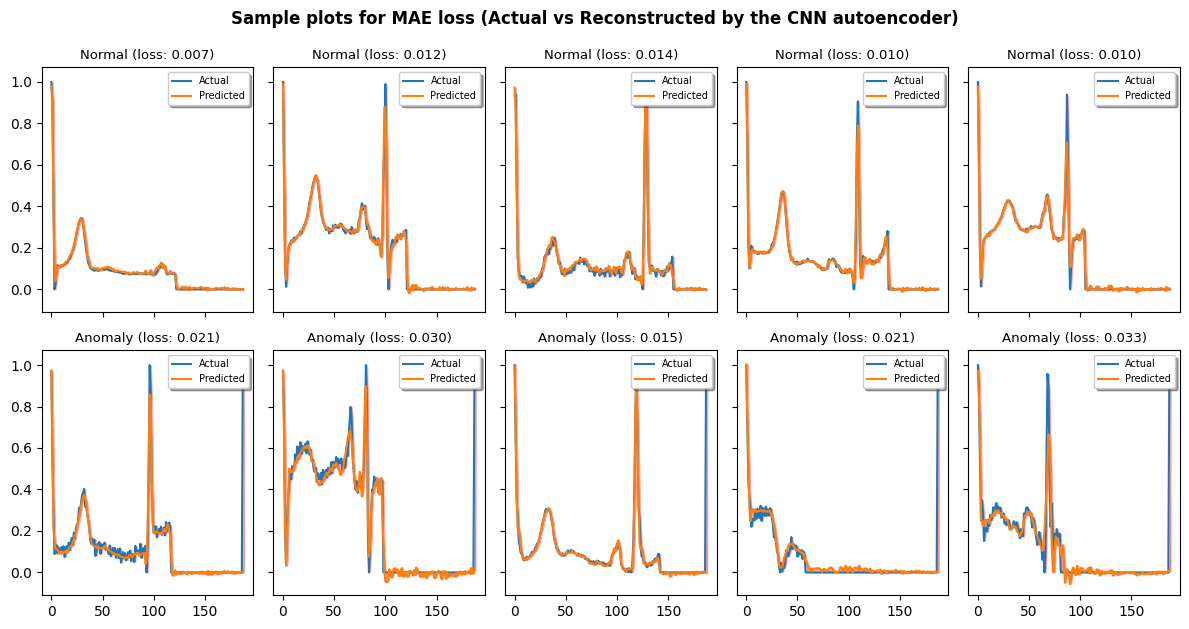

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'auto_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for GPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy using MSE: 25.98%
Validation Reconstruction Error using MSE: 0.13127999924914197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


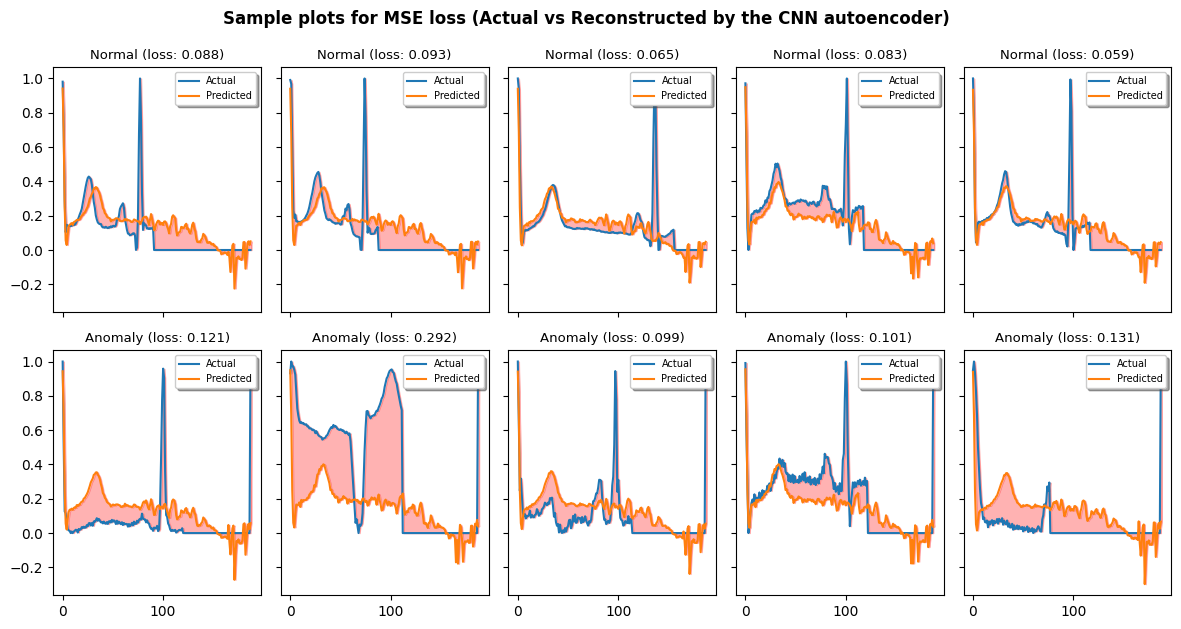

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'auto_encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for GPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy using Huber: 25.58%
Validation Reconstruction Error using Huber: 0.13195179373875968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


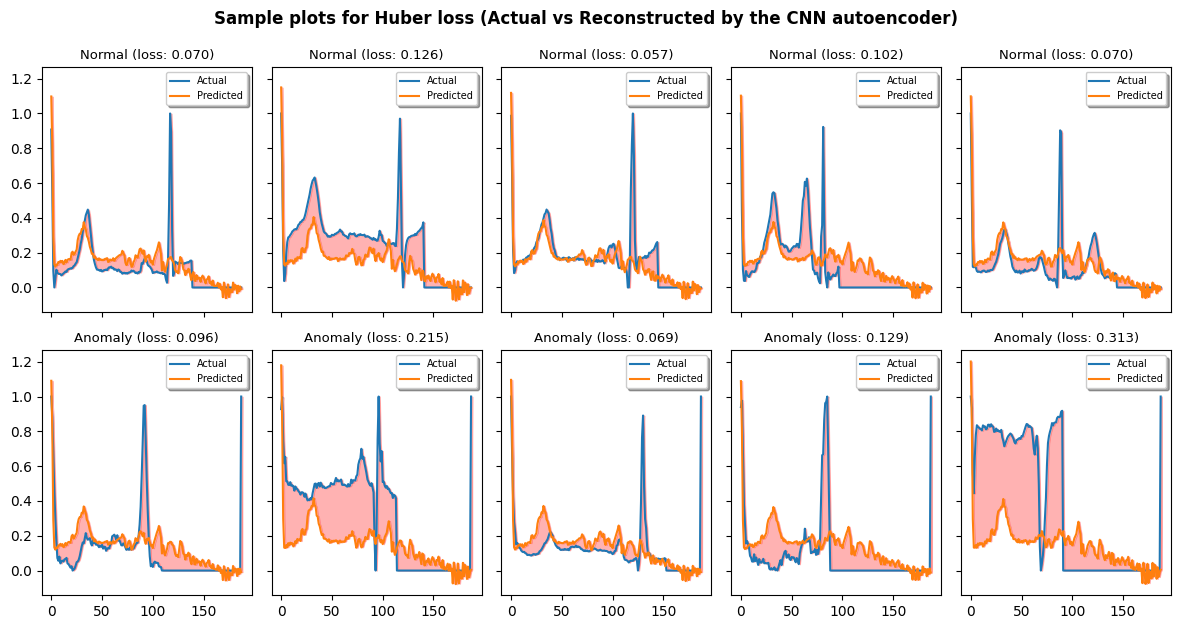

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'auto_encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for GPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy using CosineSimilarity: 15.59%
Validation Reconstruction Error using CosineSimilarity: 51.12855206375273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


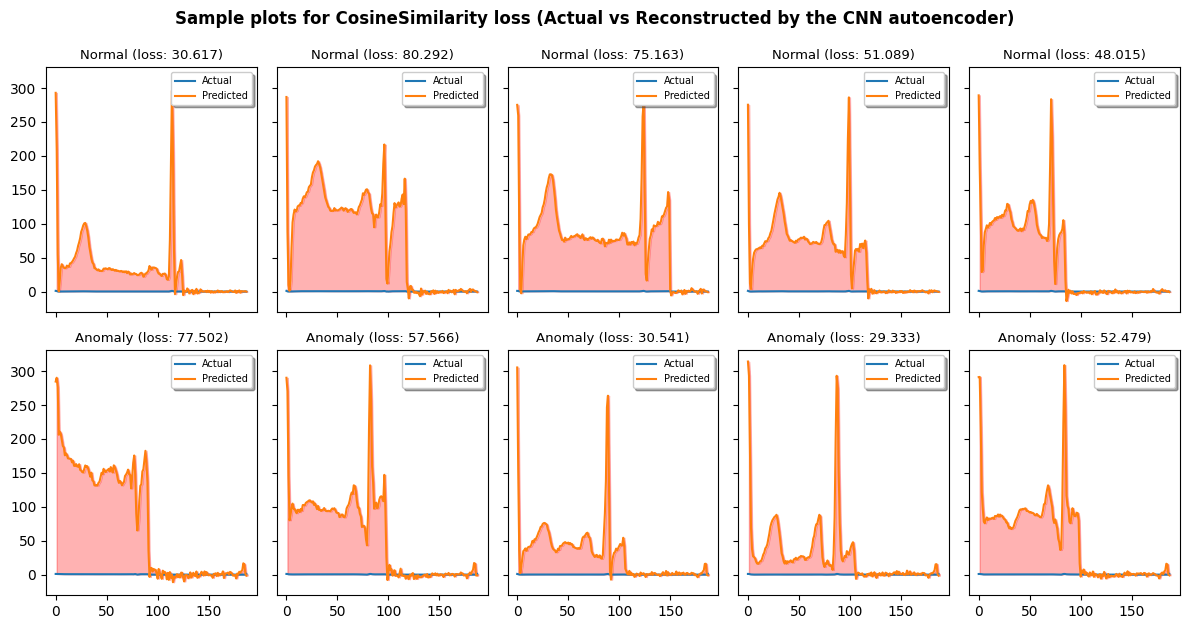

Best Model uses MAE with average validation error: 0.027002227740220913


In [ ]:
# Train and evaluate models for each loss function
for name, loss_function in loss_functions.items():
    # Define and compile the model
    model = AutoEncoder(input_dim, latent_dim)
    model.build((None, input_dim))
    # Check if the machine is using an M1/M2 processor
    if "macOS-13.5.2-arm64-arm-64bit" in platform.platform() and "arm64" in platform.machine():
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss=loss_function)
        print("Using legacy optimizer for M1/M2 Mac.")
    elif tf.config.list_physical_devices('GPU'):  # Check if there are any GPUs available
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)
        print("Using standard optimizer for GPU.")
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)
        print("Using standard optimizer for conventional CPU.")


    # Train the model
    model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Calculate the threshold based on the training data
    train_errors = get_reconstruction_error(model, X_train)
    threshold = np.percentile(train_errors, 95)  # 95th percentile as threshold

    # Evaluate the model on combined validation data (normal + anomaly) using the calculated threshold
    val_errors = get_reconstruction_error(model, X_combined_test)
    y_pred_val = np.array(val_errors > threshold, dtype=int)

    accuracy = accuracy_score(y_test, y_pred_val)

    print(f"Validation Accuracy using {name}: {accuracy:.2%}")
    print(f"Validation Reconstruction Error using {name}: {np.mean(val_errors)}")

    # After training, visualize the reconstructions for this specific model
    fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6))
    random_indexes = np.random.randint(0, len(X_train), size=5)
    for i, idx in enumerate(random_indexes):
        data = X_train[[idx]]
        plot_examples(model, data, ax=axes[0, i], title="Normal")
    for i, idx in enumerate(random_indexes):
        data = anomaly[[idx]]
        plot_examples(model, data, ax=axes[1, i], title="Anomaly")
    plt.tight_layout()
    fig.suptitle(f"Sample plots for {name} loss (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
    plt.show()

    # Check if current model is the best
    if np.mean(val_errors) < best_loss:
        best_loss = np.mean(val_errors)
        best_model = model
        best_loss_function = name

print(f"Best Model uses {best_loss_function} with average validation error: {best_loss}")

# Evaluation


In [ ]:
threshold = np.percentile(get_reconstruction_error(best_model, X_train), 95)
normal_errors = get_reconstruction_error(best_model, X_test)
anomaly_errors = get_reconstruction_error(best_model, anomaly)
y_pred_normal = classify_errors(normal_errors, threshold)
y_pred_anomaly = classify_errors(anomaly_errors, threshold)
y_true_normal = np.zeros_like(y_pred_normal)
y_true_anomaly = np.ones_like(y_pred_anomaly)
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])
y_true = np.concatenate([y_true_normal, y_true_anomaly])
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")=
print(f"F1 Score: {f1 * 100:.2f}%")

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 85.16%
Precision: 99.59%
Recall: 84.65%
F1 Score: 91.52%


Text(0.5, 36.72222222222221, 'Predicted Class')

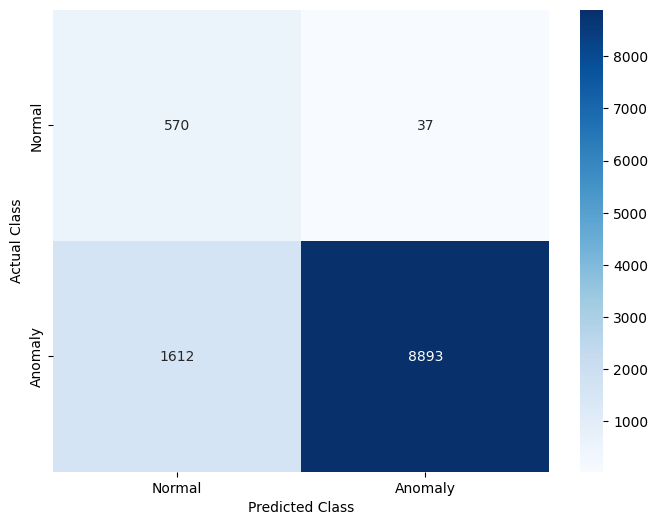

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Compile model and convert to TinyML


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

class TinyAutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(TinyAutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(188, activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = 187
latent_dim = 16
model = TinyAutoEncoder(input_dim, latent_dim)

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, X_train, epochs=10)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1110
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0309
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0057


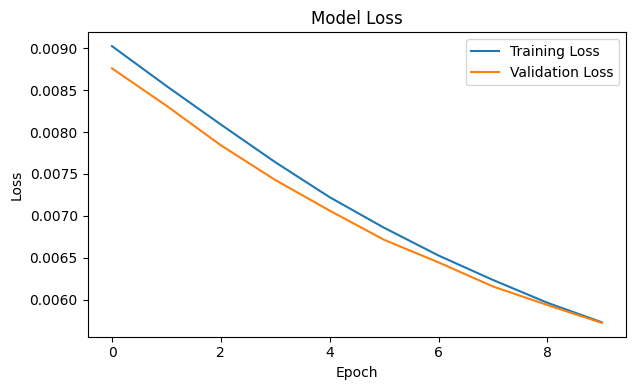

Final Training Loss: 0.005730818957090378
Final Validation Loss: 0.00572349363937974


In [ ]:
history = model.fit(X_train, X_train, epochs=10, validation_split=0.2, verbose=1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

# Quantize TinyML model

In [ ]:
pip install tensorflow==2.8.0

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7c025a3c1000>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7c025a3c1000>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7c025a3c26b0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7c025a3c26b0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Saved artifact at '/tmp/tmp83dll_ha'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 188), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 188), dtype=tf.float32, name=None)
Captures:
  136352212973552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136352211200032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136352211197744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136352211199328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136352211204960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136352211202672: TensorSpec(shape=(), dtype=tf.resource, na

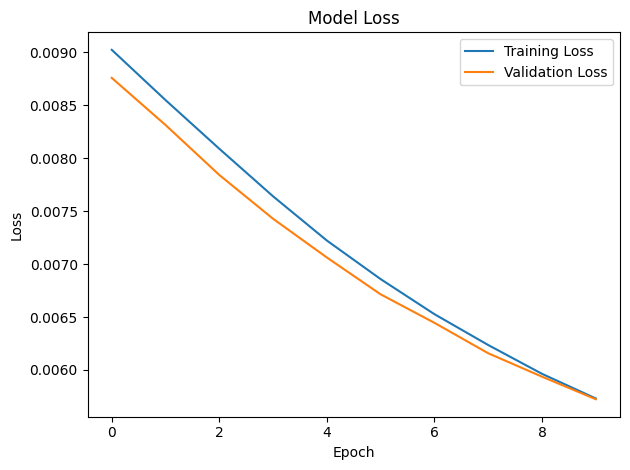

Final Training Loss: 0.005730818957090378
Final Validation Loss: 0.00572349363937974


In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])